![header](header.png)

# Procesamiento Digital de Señales en Sistemas Embebidos

---

# TP5: Procemamiento mediante ML *(parte 1)*

## Introducción

Imagine que nuestro conjunto de datos consta de los números en la parte superior de la figura a la izquierda. Tenemos dos 1 y cinco 0 (los 1 y los 0 son nuestras clases) y deseamos separar las clases usando sus características. Las características son el color (rojo frente a azul) y si la observación está subrayada o no. Entonces cómo podemos hacer esto?

El color parece una característica bastante obvia para dividir, ya que todos menos uno de los 0 son azules. Entonces podemos usar la pregunta, "¿Es rojo?" para dividir nuestro primer nodo. Puede pensar en un nodo del árbol como el punto donde la ruta se divide en dos: las observaciones que cumplen los criterios descienden por la rama Sí y las que no descienden por la rama No.

La rama No (los azules) es todo 0 ahora, así que hemos terminado allí, pero nuestra rama Sí aún se puede dividir aún más. Ahora podemos usar la segunda función y preguntar: "¿Está subrayado?" para hacer una segunda división.

Los dos 1 que están subrayados bajan por la subrama Sí y el 0 que no está subrayado baja por la subrama derecha y hemos terminado. Nuestro árbol de decisiones pudo usar las dos características para dividir los datos perfectamente.

<img src="tree.png" alt="Drawing" align="middle" style="width: 1000px;"/>


## El clasificador Random Forest
Random forest, como su nombre lo indica, consiste en una gran cantidad de árboles de decisión individuales que operan como un conjunto. Cada árbol individual en el bosque aleatorio genera una predicción de clase y la clase con más votos se convierte en la predicción del modelo.


<center><img src="forest.png" alt="Drawing" style="width: 750px;"/></center>


El concepto fundamental detrás del bosque aleatorio es simple pero poderoso: la sabiduría de las multitudes.

## Proceso de captura de datos, entrenamiento y generación de modelos
<center><img src="ml.png" alt="Drawing" style="width: 1250px;"/></center>


## Generación del Dataset
<center><img src="ml_2.png" alt="Drawing" style="width: 1250px;"/></center>


In [1]:
try:
    import micromlgen
except:
    !pip install micromlgen

In [2]:
# Incluir librerías
import numpy as np
from sklearn.metrics import recall_score
from micromlgen import port
from sklearn import tree
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
import process_data
import process_code
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score, confusion_matrix
import seaborn as sns

In [3]:
#%% Lectura del dataset
folder = 'dataset' # Carpeta donde se almacenan los .csv

#Procesamos los archivos para obtener el dataset junto con el diccionario de clases
dataset, classmap = process_data.process_data(folder)

dataset\DO.csv
Se encontraron 84 eventos de la clase:  DO
dataset\FA.csv
Se encontraron 55 eventos de la clase:  FA
dataset\LAm.csv
Se encontraron 52 eventos de la clase:  LAm
dataset\MI.csv
Se encontraron 38 eventos de la clase:  MI
dataset\RE.csv
Se encontraron 58 eventos de la clase:  RE
dataset\SOL.csv
Se encontraron 95 eventos de la clase:  SOL


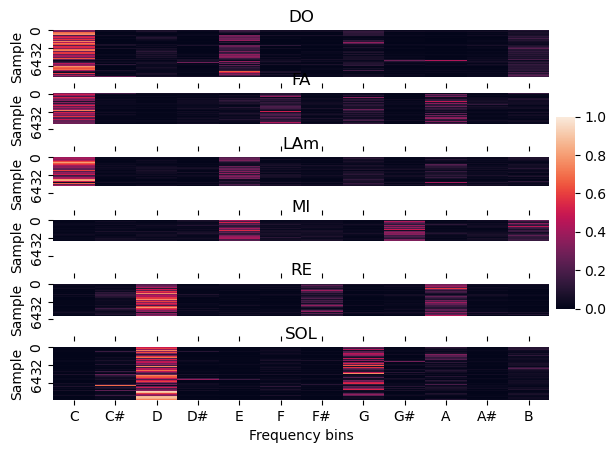

In [4]:
N = 12
#Separamos el dataset del vector con la información que codifica la clase
X, y = dataset[:, :-1], dataset[:, -1]

#Contamos el número de tonos para cada clase
count = np.unique(y, return_counts=True)
pos = np.ones(len(count[0])+1)
pos[0] = 0

#Se arma vector que permite graficar cada tono en un Heatmap independiente
for i in range(len(count[0])):
    pos[i+1] =  pos[i] + count[1][i]
    

fig, axn = plt.subplots( len(count[0]),1, sharex=True, sharey=True)
cbar_ax = fig.add_axes([.91, .3, .03, .4])

#fig.set_figwidth(25)
values = ['C','C#','D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']
for i, ax in enumerate(axn.flat):
    sns.heatmap(X[int(pos[i]):int(pos[i+1])], ax=ax,
                cbar=i == 0,
                vmin=0, vmax=1,
                cbar_ax=None if i else cbar_ax)
    ax.set_title(classmap[i])
    ax.set(xlabel = "Frequency bins")
    ax.set_xticklabels(values)
    ax.set(ylabel = "Sample")
    
#fig.tight_layout(rect=[0,0,0.9,1])   
#fig.set_figheight(15)   
#fig.set_figwidth(25)

plt.show()

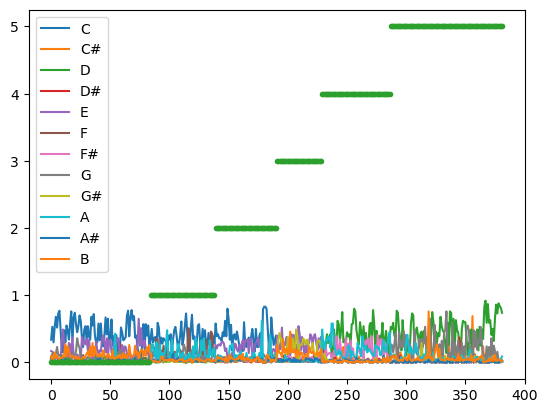

In [5]:
plt.plot(X)
plt.legend(values)
plt.plot(y, '.')

-------Accuracy-------
0.7973856209150327


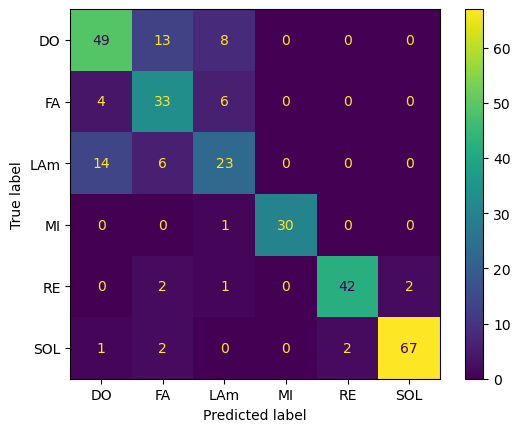

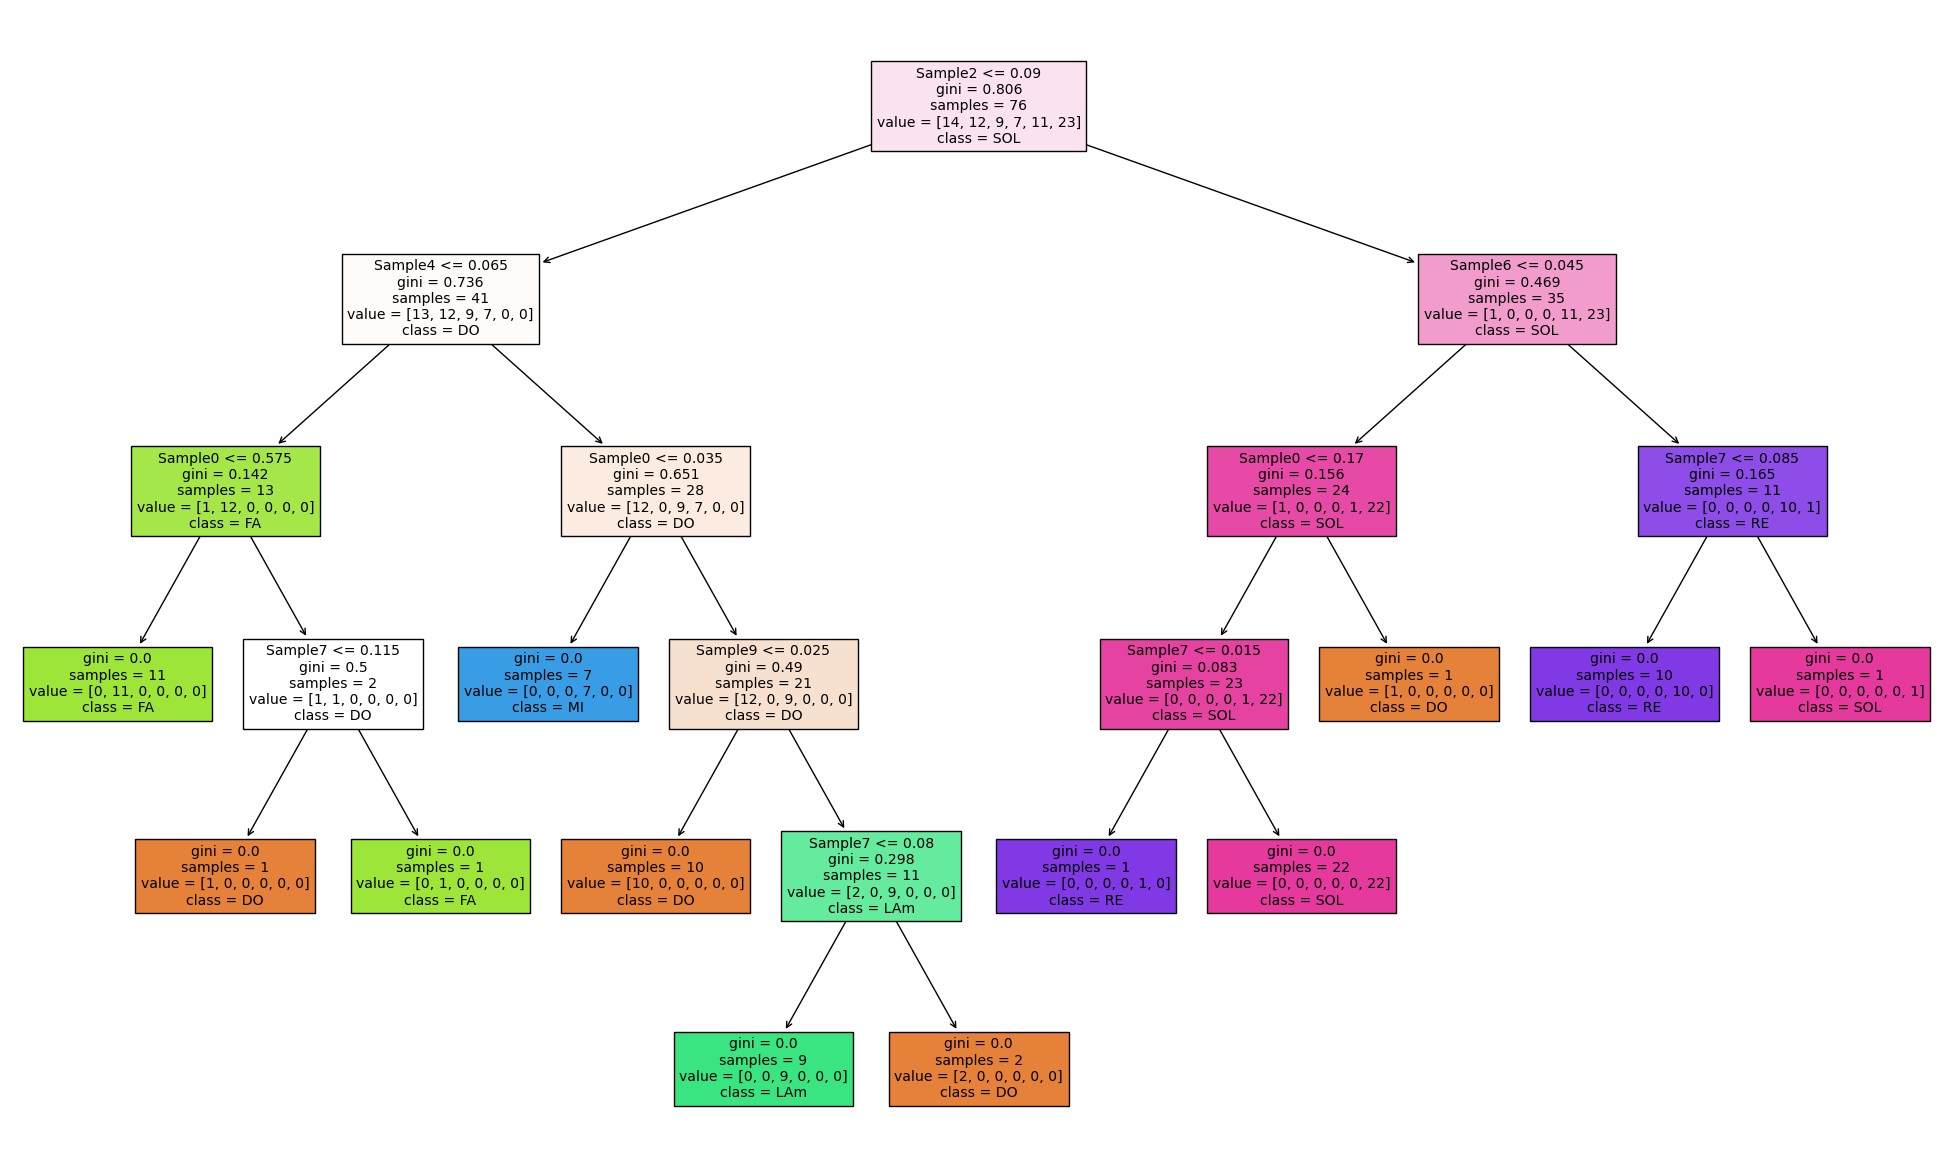

In [6]:
#Separamos el dataset y el vector de salida en partes iguales para el entrenamiento y testeo
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8, random_state=0)

#Creamos un modelo de tipo Random Forrest y le pasamos la partición del dataset y salida
# de testeo
clf = RandomForestClassifier(n_estimators=20, max_features = 10, bootstrap=False).fit(X_train, y_train)

#Utilizo el modelo entrenado para obtener la predicción de las salidas de testo
y_pred_test = clf.predict(X_test)

#Graficamos la matriz de confusión obtenida a partir de los datos de testeo
classmap_list = list(classmap.values())
cm = confusion_matrix(y_test, y_pred_test, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=classmap_list)
disp.plot()

#Utilizo la predicción del punto anterior para comparar con la salida real y obtener
# el score del modelo
print("-------Accuracy-------")
print(accuracy_score(y_test, y_pred_test))

#Exporto los archivos del modelo para utilizar en el ESP32
process_code.process_classifier(port(clf, classname="Classifier", classmap=classmap),'RandomForest')

#Creamos un vector de "features", en este caso los features son  los mismos elemnetos del vector
#termporal de la señañ que estamos queriendo identificar
features = {}
for i in range(len(dataset[0,:])):
    features[i] = "Sample"+str(i)

#Graficamos algunos de los arboles
for i in range(1):    
    plt.figure(figsize=(25,15))
    tree.plot_tree(clf.estimators_[i], filled=True,feature_names = features, class_names = classmap)